<img src="../static/images/iterables.png"  width="240">

# Iterables

Some steps in a neuroimaging analysis are repetitive. Running the same preprocessing on multiple subjects or doing statistical inference on multiple files. To prevent the creation of multiple individual scripts, Nipype has as execution plugin, called **``iterables``**.

The main homepage has a [nice section](http://nipype.readthedocs.io/en/latest/users/mapnode_and_iterables.html) about ``MapNode`` and ``iterables`` if you want to learn more. Also, if you are interested in more advanced procedures, such as synchronizing multiple iterables or using conditional iterables, check out [synchronize and intersource](http://nipype.readthedocs.io/en/latest/users/joinnode_and_itersource.html#synchronize).

For example, let's assume we have a node (A) that does simple skull stripping, followed by a node (B) that does isometric smoothing. Now, let's say, that we are curious about the effect of different smoothing kernels. Therefore, we want to run the smoothing node with FWHM set to 2mm, 8mm and 16mm.

In [1]:
from nipype import Node, Workflow
from nipype.interfaces.fsl import BET, IsotropicSmooth

# Initiate a skull stripping Node with BET
skullstrip = Node(BET(mask=True,
                      in_file='/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'),
                  name="skullstrip")

Create a smoothing Node with IsotropicSmooth

In [2]:
isosmooth = Node(IsotropicSmooth(), name='iso_smooth')

Now, to use ``iterables`` and therefore smooth with different ``fwhm`` is as simple as that:

In [3]:
isosmooth.iterables = ("fwhm", [4, 8, 16])

And to wrap it up. We need to create a workflow, connect the nodes and finally, can run the workflow in parallel.

In [4]:
# Create the workflow
wf = Workflow(name="smoothflow")
wf.base_dir = "/output"
wf.connect(skullstrip, 'out_file', isosmooth, 'in_file')

# Run it in parallel (one core for each smoothing kernel)
wf.run('MultiProc', plugin_args={'n_procs': 3})

170730-12:57:00,694 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
170730-12:57:00,714 workflow INFO:
	 Running in parallel.
170730-12:57:00,728 workflow INFO:
	 Executing: skullstrip ID: 0
170730-12:57:00,743 workflow INFO:
	 Executing node skullstrip in dir: /output/smoothflow/skullstrip
170730-12:57:00,783 workflow INFO:
	 Running: bet /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz /output/smoothflow/skullstrip/sub-01_ses-test_T1w_brain.nii.gz -m
170730-12:57:04,913 workflow INFO:
	 [Job finished] jobname: skullstrip jobid: 0
170730-12:57:04,916 workflow INFO:
	 Executing: iso_smooth.aI.a0 ID: 1
170730-12:57:04,925 workflow INFO:
	 Executing: iso_smooth.aI.a1 ID: 2
170730-12:57:04,929 workflow INFO:
	 Executing node iso_smooth.aI.a0 in dir: /output/smoothflow/_fwhm_4/iso_smooth
170730-12:57:04,938 workflow INFO:
	 Executing: iso_smooth.aI.a2 ID: 3
170730-12:57:04,941 workflow INFO:
	 Executing node iso_smooth.aI.a1 in dir: /output/sm

If we visualize the graph with ``exec``, we can see where the parallelization actually takes place.

170730-12:57:19,314 workflow INFO:
	 Generated workflow graph: /output/smoothflow/graph.dot.png (graph2use=exec, simple_form=True).


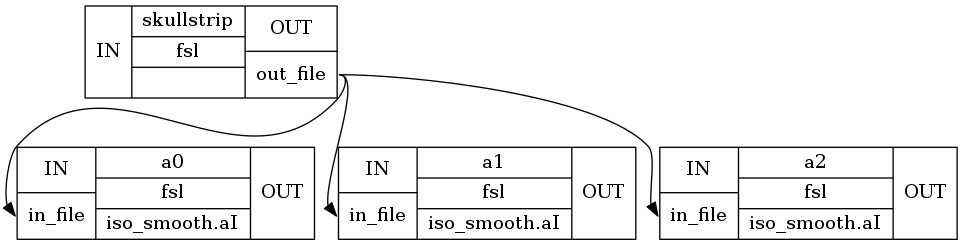

In [5]:
# Visualize the detailed graph
from IPython.display import Image
wf.write_graph(graph2use='exec', format='png', simple_form=True)
Image(filename='/output/smoothflow/graph_detailed.dot.png')

If you look at the structure in the workflow directory, you can also see, that for each smoothing, a specific folder was created, i.e. ``_fwhm_16``.

In [6]:
!tree /output/smoothflow -I '*txt|*pklz|report*|*.json|*js|*.dot|*.html'

/output/smoothflow
├── _fwhm_16
│   └── iso_smooth
│       ├── _report
│       └── sub-01_ses-test_T1w_brain_smooth.nii.gz
├── _fwhm_4
│   └── iso_smooth
│       ├── _report
│       └── sub-01_ses-test_T1w_brain_smooth.nii.gz
├── _fwhm_8
│   └── iso_smooth
│       ├── _report
│       └── sub-01_ses-test_T1w_brain_smooth.nii.gz
├── graph.dot.png
├── graph_detailed.dot.png
└── skullstrip
    ├── _report
    └── sub-01_ses-test_T1w_brain.nii.gz

11 directories, 6 files


Now, let's visualize the results!

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


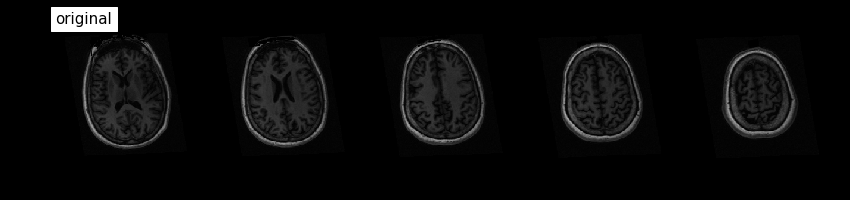

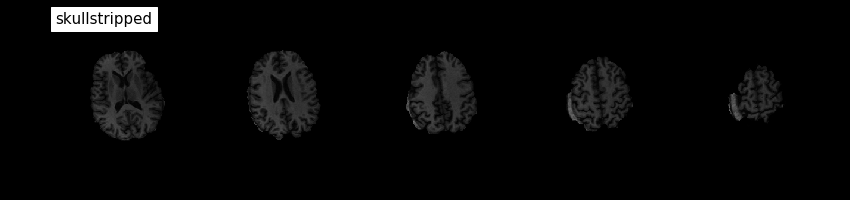

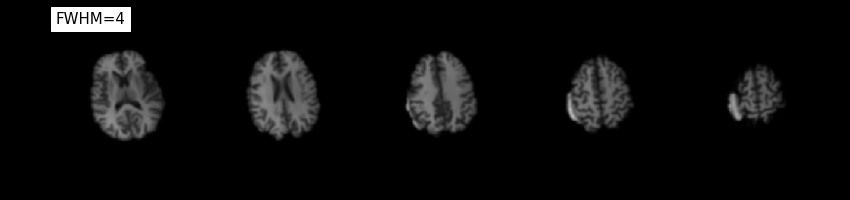

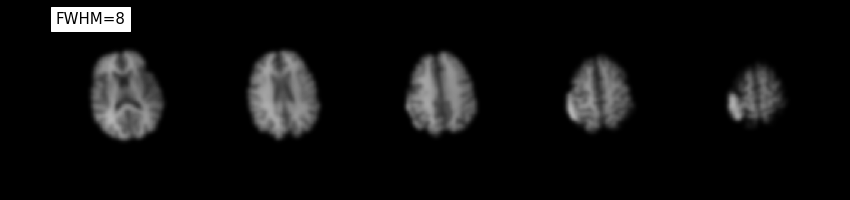

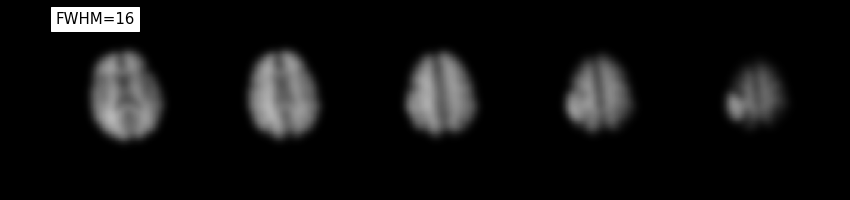

In [7]:
%pylab inline
from nilearn import plotting
plotting.plot_anat(
    '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz', title='original',
    display_mode='z', cut_coords=(-20, -10, 0, 10, 20), annotate=False)
plotting.plot_anat(
    '/output/smoothflow/skullstrip/sub-01_ses-test_T1w_brain.nii.gz', title='skullstripped',
    display_mode='z', cut_coords=(-20, -10, 0, 10, 20), annotate=False)
plotting.plot_anat(
    '/output/smoothflow/_fwhm_4/iso_smooth/sub-01_ses-test_T1w_brain_smooth.nii.gz', title='FWHM=4',
    display_mode='z', cut_coords=(-20, -10, 0, 10, 20), annotate=False)
plotting.plot_anat(
    '/output/smoothflow/_fwhm_8/iso_smooth/sub-01_ses-test_T1w_brain_smooth.nii.gz', title='FWHM=8',
    display_mode='z', cut_coords=(-20, -10, 0, 10, 20), annotate=False)
plotting.plot_anat(
    '/output/smoothflow/_fwhm_16/iso_smooth/sub-01_ses-test_T1w_brain_smooth.nii.gz', title='FWHM=16',
    display_mode='z', cut_coords=(-20, -10, 0, 10, 20), annotate=False)

# ``IdentityInterface`` (special use case of ``iterabels``)

A special use case of ``iterables`` is the ``IdentityInterface``. The ``IdentityInterface`` interface allows you to create ``Nodes`` that simple identity mapping, i.e. ``Nodes`` that only work on parameters/strings.

For example, let's say you want to run a preprocessing workflow over 5 subjects, with each having two runs and applying 2 different smoothing kernel (as is done in the [Preprocessing Example](example_preprocessing.ipynb)), we can do this as follows:

In [8]:
# First, let's specify the list of input variables
subject_list = ['sub-01', 'sub-02']
fwhm_widths = [4, 8]

Now, we can create the IdentityInterface Node

In [9]:
from nipype import IdentityInterface
infosource = Node(IdentityInterface(fields=['subject', 'fwhm']),
                  name="infosource")
infosource.iterables = [('subject', subject_list),
                        ('fwhm', fwhm_widths)]

That's it. Now, we can connect the output fields of this ``infosource`` node like any other node to wherever we want.

In [10]:
infosource.outputs


fwhm = <undefined>
subject = <undefined>